/home/benomin/PycharmProjects/BA-Approoximation-Feature-Attribution/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


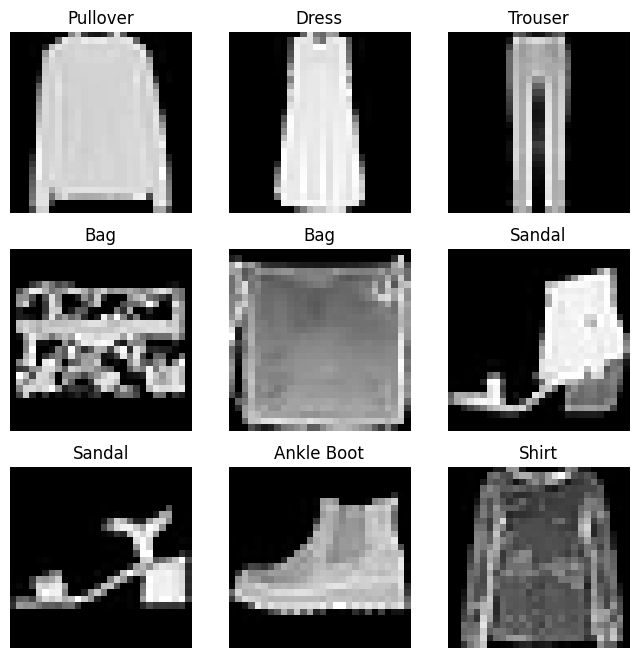

In [1]:
import torch
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
#from approx_attributes import *
from captum.attr import InputXGradient,IntegratedGradients,Saliency


train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False)

In [2]:


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 3*3*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    i = 0
    for batch_idx, (data, target) in enumerate(dataloader):
        i +=1
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total

    print(f'Train Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

if os.path.isfile("modelCnn.pth"):

    state_dict = torch.load("modelCnn.pth", map_location=torch.device(device))

    model.load_state_dict(state_dict)
    model.eval()
else:

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


    train_one_epoch(model, train_loader, optimizer, device)
    torch.save(model.state_dict(), "modelCnn.pth")


In [3]:
import numpy as np

class ApproxAttribution():
    def __init__(self,model):
        self.model = model

    def grad_approx(self,h,X,target=0):
        print("Grad Approx")
        ret = []
        for elem in X:
            for index, value in np.ndenumerate(elem):
                new = elem.clone()
                new[index] += h
                res = np.abs(((self.model(new) - self.model(elem))/h).detach().numpy())
                ret.append(res)
                #print(res)
        return np.array(ret)[:,0,target]

    def int_grad_approx(self,h,X,baseline = 0,riemann_step = 50,target=0):
        ret = []
        for elem in X:
            for index, value in np.ndenumerate(elem):
                new = elem.clone()
                new[index] += h
                attr = 0
                for i in range(1,riemann_step+1):
                    scaled_new  = (baseline + i/riemann_step) * (new - baseline)
                    scaled_elem = (baseline + i/riemann_step) * (elem - baseline)
                    attr+= ((self.model(scaled_new) - self.model(scaled_elem))/h).detach().numpy()


                val = (attr/riemann_step) * (value-baseline)
                if np.array([np.isnan(j) for j in self.model(scaled_new).detach().numpy()]).any():
                    print("Error")
                    print((self.model(scaled_new)))


                ret.append(val)


        return np.array(ret)[:,0,target]

    def grad_x_i_approx(self,h,X,target=0):
        ret = []
        for elem in X:
            for index, value in np.ndenumerate(elem):
                new = elem.clone()
                new[index] += h



                ret.append(-1 * value * ((self.model(new) - self.model(elem))/h).detach().numpy())
        return np.array(ret)[:,0,target]


def pearson_correlation(X,Y):
    res = []
    for x,y in zip(X,Y):
        res.append(np.corrcoef(x,y)[0,1])
    return res


Grad Approx
[nan, 0.6856675399249427, 0.5189177444487392, 0.6626458913800946, 0.7152774167606012, 0.7112991381669507, 0.6750015887871467, 0.9134266906619023, 0.591962126579157, 0.6027326642059078, 0.6372486844668296, 0.7044921721487615, 0.8388228264314194, 0.8177948430295253, 0.8076649063444722, 0.7116903098170705, 0.8142298144653916, 0.7884473757423733, 0.8734643908311374, 0.8293633291349457, 0.8952250969688356, 0.8958453532383622, 0.889794300947958, 0.846894836949885, 0.7580505480210961, 0.8130037817366746, nan, nan]


/home/benomin/PycharmProjects/BA-Approoximation-Feature-Attribution/.venv/lib/python3.10/site-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/home/benomin/PycharmProjects/BA-Approoximation-Feature-Attribution/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/benomin/PycharmProjects/BA-Approoximation-Feature-Attribution/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


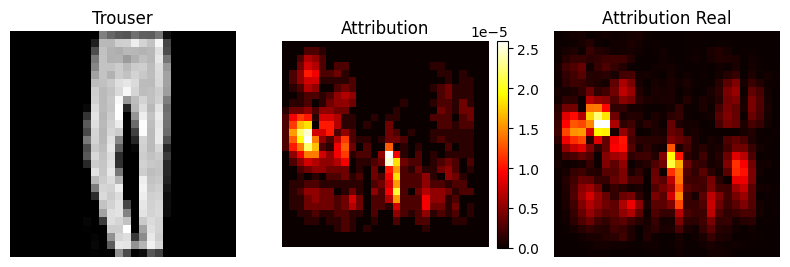

In [4]:
#from approx_attributes import *

sample_idx = torch.randint(len(train_data), size=(1,)).item()
img, label = train_data[sample_idx]
aa =  ApproxAttribution(model)
sal = Saliency(model)
ig = IntegratedGradients(model)

image = img[0]
attributions = np.random.rand(784)


attribution_map = aa.grad_approx(0.1,[img],label).reshape(28, 28)

#for elem in attribution_map:
#    print(elem)
#attribution_map = aa.int_Grad_approx(0.01,0.01,1,[img],label).reshape(28, 28)

attribution_map_real = sal.attribute(img.unsqueeze(0).float(), target=label).detach().numpy().reshape(28, 28)
#attribution_map_real = ig.attribute(img.unsqueeze(0).float(), target=label,baselines=torch.zeros_like(img, dtype=torch.float)).detach().numpy().reshape(28, 28)


fig, axes = plt.subplots(1, 3,  figsize=(8, 4))


axes[0].imshow(image, cmap='gray')
axes[0].set_title(labels_map[label])
axes[0].axis('off')


im = axes[1].imshow(attribution_map, cmap='hot')
axes[1].set_title('Attribution')
axes[1].axis('off')

im = axes[2].imshow(attribution_map_real, cmap='hot')
axes[2].set_title('Attribution Real')
axes[2].axis('off')


fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
#plt.show()
print(pearson_correlation(attribution_map,attribution_map_real))
#print(sample_idx)


# Bilder bei denen grad failt: 33524 20015 13675 4926